## Today you are a Machine Learning Engineer at the Department of Business Intelligence at Target Cosmetics!
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

This work is motivated by the publication https://arxiv.org/pdf/2102.01625.pdf

Further details available at
https://arxiv.org/pdf/2010.02503.pdf

You have access to the Target server data, specifically the Cosmetics section, such that you have NO customer facing information, but, only access to timestamped data regarding product viewing/carting/purchasing.


### The user-journey data regarding user-product interaction is given to you as follows:

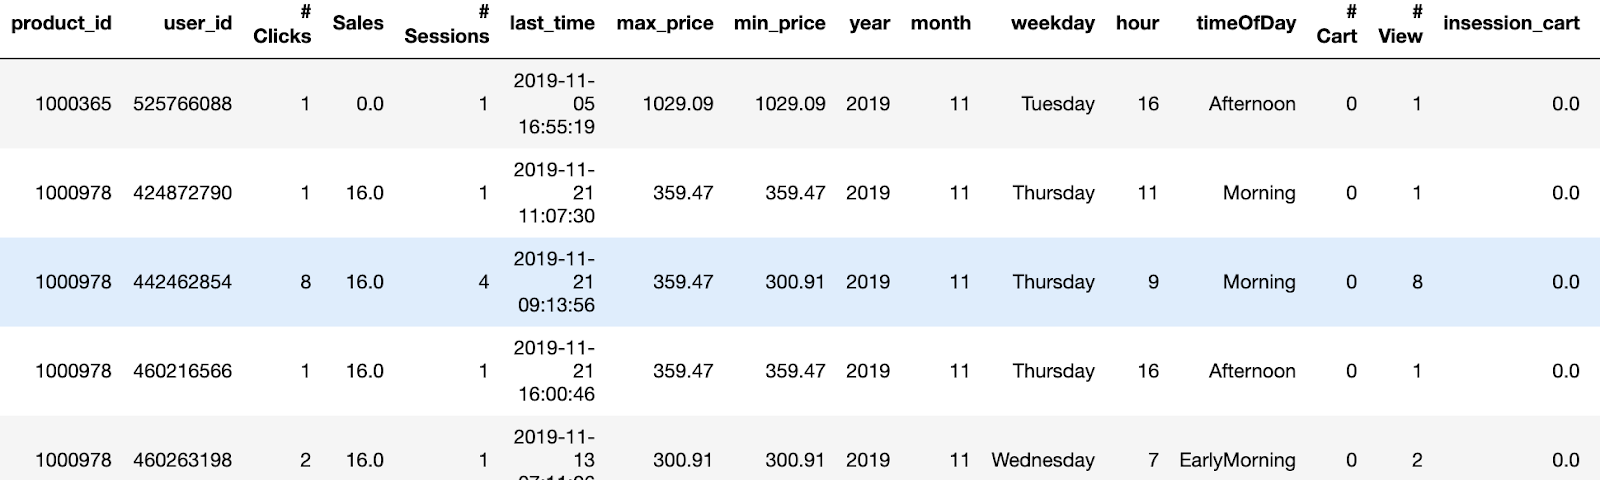

In [37]:
from IPython.display import Image
Image(filename='image10.png')

## The data above has been wrangled and converted to one-hot encoded format for this exercise.
## You have access to first 250,000 user-journeys only and you have been asked to create a proof of concept analysis based on this data. Your task is to perform the following:
### A. Find patterns between customer purchasing behaviors to identify categories of customers. I.e. how many categories of customers are there based on their purchasing rates? We have repeat customers here since people buy other cosmetics based on their past purchases.

### B.Visually inspect the customer categories to identify the distinctive categories and their corresponding descriptive features.

### Task 0: Getting familiar with the data set

In [38]:
## Importing required Libraries
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sb

In [39]:
## Get working directory
PATH = os.getcwd()
## Path to save the embedding and checkpoints generated
# LOG_DIR = PATH + '/project-tensorboard/'
# os.mkdir(LOG_DIR)
# LOG_DIR = PATH + '/project-tensorboard/log-1'
# os.mkdir(LOG_DIR)

In [40]:
PATH

'/Users/unmeshmali/Desktop/Unmesh/Lessons/FourthB/Week3/class_project'

In [41]:
LOG_DIR

'/Users/unmeshmali/Desktop/Unmesh/Lessons/FourthB/Week3/class_project/project-tensorboard/'

In [42]:
df = pd.read_csv("Cosmetics_data_2019.csv")

np.shape(df)

(250000, 36)

In [43]:
import matplotlib.pyplot as plt
YY=df.loc[:,'Purchase'].values
print(f'Percentage of interactions resulting in a purchase = {(np.sum(YY)/len(YY))*100}')

Percentage of interactions resulting in a purchase = 12.0684


In [44]:
df

,user_id,product_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,537190108,27762,2,2,4749,19.03,19.03,0,1,1,...,1,0,0,0,0,0,1,0,0,0
1,577668451,5865119,1,1,0,4.60,4.60,0,1,0,...,1,0,1,0,0,0,0,0,0,0
2,607369766,5922121,1,1,0,35.71,35.71,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,572456715,5723529,1,1,0,2.94,2.94,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,566667766,5823646,1,1,0,5.22,5.22,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,608981310,5910241,1,1,0,6.33,6.33,1,0,0,...,0,0,0,0,0,0,1,0,0,0
249996,570217837,5769929,2,2,36,4.22,4.22,0,2,0,...,1,0,1,0,0,0,0,0,0,0
249997,617180268,5881443,1,1,0,7.78,7.78,0,1,0,...,0,0,0,0,1,0,0,0,0,0
249998,563987915,5684623,2,2,3543964,8.41,8.41,0,2,0,...,0,0,0,0,0,0,1,0,0,0


### Exercise: Set the target vector y equal to the `'Purchase'` column of the DataFrame and the features array X equal to the remaining columns, minus `'user_id'` and `'product_id'`. Drop those two columns from the original DataFrame as well.

In [45]:
### START CODE HERE ###
df = df.iloc[:, 2:]

X  = df.iloc[:, :-1]
y  = df['Purchase']
### END CODE HERE ###
# Display the first few rows of the modified DataFrame
df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,2,2,4749,19.03,19.03,0,1,1,1,2,...,1,0,0,0,0,0,1,0,0,0
1,1,1,0,4.60,4.60,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,1,1,0,35.71,35.71,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,0,2.94,2.94,1,0,0,13,13,...,1,0,0,0,1,0,0,0,0,0
4,1,1,0,5.22,5.22,0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0


### Use a library of functions (`helper_functions.py`) to carry out essential tasks such as feature selection

### Using a separate library of functions increases modularity of the code without the need to copy and paste code to the notebook

In [46]:
from helper_functions import *

## Task 1: Select top features to separate purchasing vs non purchasing customers.
### You can modify the functions in helper_functions to include OLS and other feature selection mentods.
### Remember to reload the kernel (restart jupyternotebook) if you make any change to helper functions.

### Exercise: Calculate, print, and plot the feature importances, in descending order of importance. Call the appropriate function from helper_functions.py here..

Feature ranking:
1. feature 7 (0.171403)
2. feature 0 (0.168439)
3. feature 5 (0.117723)
4. feature 6 (0.101453)
5. feature 2 (0.082864)
6. feature 1 (0.062956)
7. feature 10 (0.054205)
8. feature 8 (0.053166)
9. feature 4 (0.044448)
10. feature 3 (0.042576)
11. feature 9 (0.042194)
12. feature 18 (0.004516)
13. feature 26 (0.004165)
14. feature 16 (0.004153)
15. feature 13 (0.004037)
16. feature 15 (0.003799)
17. feature 12 (0.003794)
18. feature 14 (0.003670)
19. feature 28 (0.003655)
20. feature 17 (0.003609)
21. feature 27 (0.002778)
22. feature 31 (0.002557)
23. feature 29 (0.002411)
24. feature 32 (0.002275)
25. feature 25 (0.002271)
26. feature 30 (0.002067)
27. feature 23 (0.001911)
28. feature 21 (0.001789)
29. feature 22 (0.001690)
30. feature 24 (0.001622)
31. feature 19 (0.000926)
32. feature 20 (0.000880)
33. feature 11 (0.000000)


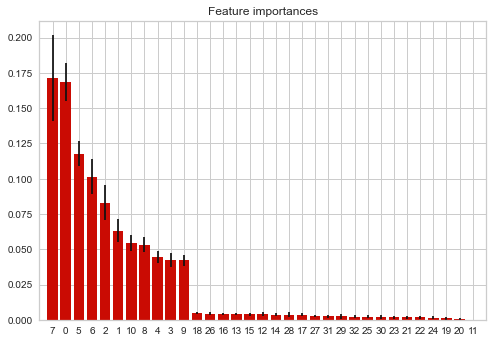

In [47]:
### START CODE HERE ###
indices, importances = return_feature_rank_from_RF(X, y)
### END CODE HERE ###

In [48]:
importances

array([0.16843865, 0.06295602, 0.0828645 , 0.04257556, 0.04444823,
       0.11772348, 0.10145311, 0.17140284, 0.05316637, 0.04219354,
       0.05420508, 0.        , 0.00379371, 0.00403717, 0.00366961,
       0.00379893, 0.0041525 , 0.00360856, 0.00451556, 0.00092583,
       0.00088037, 0.00178854, 0.00169025, 0.00191054, 0.00162219,
       0.00227127, 0.0041651 , 0.00277782, 0.00365485, 0.0024108 ,
       0.00206658, 0.00255725, 0.00227519])

### Exercise: Select features with weight > 0.025 
### 0.025 is a significant cutoff point based on the graph above, hence its choice for this exercise.
## Note: Weight cutoff is a relative process for each data set and the threshold (0.025 here) varies across data sets.

In [49]:
### START CODE HERE ###
# Extract the indices corresponding to a feature importance > 0.025
df_prep = pd.DataFrame(indices, columns = ['indices'])
df_prep['import'] = importances
df_prep.set_index('indices', inplace =True)
idx = df_prep[df_prep['import'] > 0.025].index

# Extract the names of the associated feature columns
selected_columns = df.columns[idx.values]

### END CODE HERE ###
print(idx)
print(selected_columns)

Int64Index([7, 0, 5, 6, 2, 1, 10, 8, 4, 3, 9], dtype='int64', name='indices')
Index(['NumRemove', 'NumOfEventsInJourney', 'NumCart', 'NumView',
       'interactionTime', 'NumSessions', 'InsessionRemove', 'InsessionCart',
       'minPrice', 'maxPrice', 'InsessionView'],
      dtype='object')


### Exercise: Use the selected columns as your training data

In [50]:
### START CODE HERE ###
X_train = df[selected_columns]
y_train = df['Purchase']
### END CODE HERE ###
print(X_train.shape)

(250000, 11)


### Task 2: Apply dimensionality reduction (to speed up) and clustering. Analyze optimal number of clusters using PCA vs. t-SNE. But complete this exercise using PCA only.
### t-SNE is very slow, so verify performance (#clusters) for 10k samples using PCA and t-SNE
#Question: Do you need to normalize features in range [0,1] prior to PCA or t-SNE? When would normalization help and when would it not help?


## Submit your response below 

### [OPTION 1]: apply PCA followed by Elbow method and Yellowbrick clustering

### Exercise: Compute a reduced features dataset with 5 principal components

In [51]:
X_train_10k = X_train.iloc[0:10000, :]

In [52]:
### START CODE HERE ###
pca = PCA(n_components=5)

#Using first 10k samples
X_red = pca.fit(X_train).transform(X_train)
### END CODE HERE ###
print(X_red.shape)

(250000, 5)


### Exercise: Apply $k$-means clustering with $k \in [1, 20]$ to the reduced features data. Visualize the associated distortion scores and computational times.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
CPU times: user 6min 34s, sys: 13 s, total: 6min 47s
Wall time: 1min 52s


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

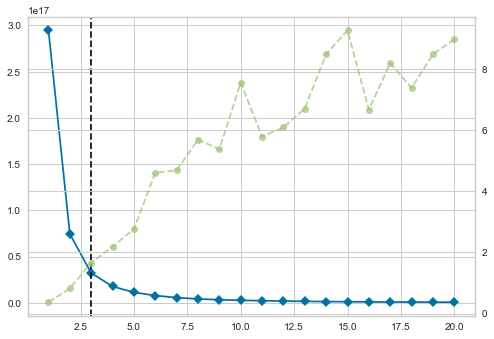

In [53]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

### START CODE HERE ###
# Instantiate the clustering model and visualizer
test = np.arange(1,21)
print(test)
model = KMeans()
visualizer = KElbowVisualizer(model, k=np.arange(1,21))
# Fit the visualizer to the reduced features data
%time visualizer.fit(X_red)
### END CODE HERE ###
#visualizer.show() 

### Exercise: Assume 3 components to be extracted and perplexity of 2. This can take a long time. Use first 10k samples to speed up.

In [54]:
from sklearn.manifold import TSNE
### START CODE HERE ###
X_red_t = TSNE(n_components=3, perplexity = 2).fit_transform(X_train_10k)
### END CODE HERE ###

### [OPTION 2]: Apply t-SNE followed by Elbow method and Yellowbrick clustering. 

### Exercise: Apply $k$-means clustering with $k \in [1, 20]$ to the t-SNE reduced features data. Visualize the associated distortion scores and computational times.

CPU times: user 41.6 s, sys: 1.46 s, total: 43.1 s
Wall time: 11.2 s


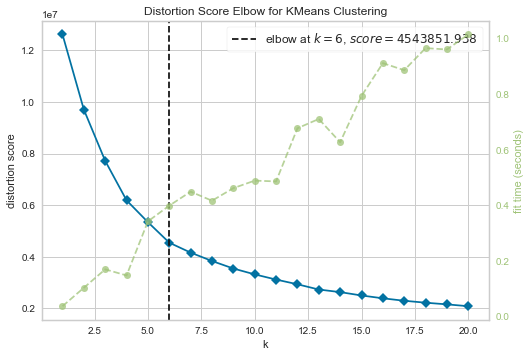

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
### START CODE HERE ###
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=np.arange(1,21))
# Fit the visualizer to the t-SNE reduced features data
%time visualizer.fit(X_red_t)        
### END CODE HERE ###
visualizer.show() 
# Ideally you should have similar optimal cluster numbers for both PCA and t-SNE

In [56]:
X_red_t.shape

(10000, 3)

### Exercise: Assign cluster IDs to all the PCA-reduced data samples and store the new data as a csv [before Lunch Break]

In [57]:
X_red.shape

(250000, 5)

In [60]:
### START CODE HERE 
#Enter the optimal number of clusters here from the Elbow method
n = 3 
# Instantiate the clustering model
clusters = KMeans(n_clusters = n)
# Assign the points in the reduced dataset to clusters
C_vals = np.array(clusters.fit_predict(X_red))
### END CODE HERE ###
print(np.unique(C_vals))

[0 1 2]


### Save the data and associated clusters

In [62]:
X_save = pd.DataFrame(df[selected_columns])
X_save['Purchase'] = df.iloc[:,-1]
X_save['ClusterID'] = C_vals
X_save.head()

,NumRemove,NumOfEventsInJourney,NumCart,NumView,interactionTime,NumSessions,InsessionRemove,InsessionCart,minPrice,maxPrice,InsessionView,Purchase,ClusterID
0,1,2,0,1,4749,2,6,1,19.03,19.03,2,0,0
1,0,1,0,1,0,1,0,0,4.60,4.60,1,0,0
2,0,1,0,1,0,1,0,0,35.71,35.71,1,0,0
3,0,1,1,0,0,1,16,13,2.94,2.94,13,0,0
4,0,1,0,1,0,1,0,0,5.22,5.22,3,0,0


In [63]:
X_save.to_csv('Clustered_data_cosmetics_tsne.csv', index=False)

### Task 3: Visualize the clusters [Instructor Led]
Jupyter notebook + Google colab version https://colab.research.google.com/drive/1-PUVjf4eNO8QzF27lbBg6OT-yTNlBgD7

In [67]:
#Load the clustered data and visualize using tensorboard
X_train = pd.read_csv("Clustered_data_cosmetics_tsne.csv")
X=X_train.iloc[:,0:-2].values

X_train.head()

,NumRemove,NumOfEventsInJourney,NumCart,NumView,interactionTime,NumSessions,InsessionRemove,InsessionCart,minPrice,maxPrice,InsessionView,Purchase,ClusterID
0,1,2,0,1,4749,2,6,1,19.03,19.03,2,0,0
1,0,1,0,1,0,1,0,0,4.60,4.60,1,0,0
2,0,1,0,1,0,1,0,0,35.71,35.71,1,0,0
3,0,1,1,0,0,1,16,13,2.94,2.94,13,0,0
4,0,1,0,1,0,1,0,0,5.22,5.22,3,0,0


In [68]:
pca=PCA(n_components=5)
X1=pca.fit_transform(X)
print(X1.shape)

(250000, 5)


In [69]:
#version 1
def register_embedding(embedding_tensor_name, meta_data_fname, log_dir):
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_tensor_name
    embedding.metadata_path = meta_data_fname
    projector.visualize_embeddings(log_dir, config)

def save_labels_tsv(labels, filepath, log_dir):
    with open(os.path.join(log_dir, filepath), 'w') as f:
        for label in labels:
            f.write('{}\n'.format(label))


In [70]:
META_DATA_FNAME = 'meta_cos_reduction1.tsv'  # Labels will be stored here
EMBEDDINGS_TENSOR_NAME = 'sample_data_cos_reduction1'
EMBEDDINGS_FPATH = os.path.join(LOG_DIR, EMBEDDINGS_TENSOR_NAME + '.ckpt')
STEP = 0

register_embedding(EMBEDDINGS_TENSOR_NAME, META_DATA_FNAME, LOG_DIR)
save_labels_tsv(C_vals, META_DATA_FNAME, LOG_DIR)#version 1

In [71]:
tf.compat.v1.disable_eager_execution()
tensor_embeddings = tf.Variable(X1, name=EMBEDDINGS_TENSOR_NAME)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
saver.save(sess, EMBEDDINGS_FPATH, STEP)
sess.close()

In [78]:
#Attach an image of the optimal clusters and their relative position in t-SNE
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 94808), started 0:07:54 ago. (Use '!kill 94808' to kill it.)

### Task 4: Analysis of clusters.
Now that the records have been clustered, do the following 2 tasks:
1. Do the different clusters vary in their purchase ratio? If so by how much?
2. Plot the discriminating charecteristics of each feature to separate purchase vs not-purchase events [Hint: Seaborn plot]

### Exercise: Find the unique cluster IDs

In [80]:
X_train.head()

,NumRemove,NumOfEventsInJourney,NumCart,NumView,interactionTime,NumSessions,InsessionRemove,InsessionCart,minPrice,maxPrice,InsessionView,Purchase,ClusterID
0,1,2,0,1,4749,2,6,1,19.03,19.03,2,0,0
1,0,1,0,1,0,1,0,0,4.60,4.60,1,0,0
2,0,1,0,1,0,1,0,0,35.71,35.71,1,0,0
3,0,1,1,0,0,1,16,13,2.94,2.94,13,0,0
4,0,1,0,1,0,1,0,0,5.22,5.22,3,0,0


In [81]:
### START CODE HERE ###
# Get all the values in the 'ClusterID' column
column_values = X_train['ClusterID']
# Compute the unique cluster ID values
unique_values_a = column_values.unique()
# Sort the unique cluster ID values
unique_values = np.sort(unique_values_a)
### END CODE HERE ###
print(unique_values)

[0 1 2]


### Exercise: For each cluster, calculate the representation percentage (i.e. what percentage of the dataset's samples belong to that cluster) and purchase percentage (i.e. what percentage of samples in each cluster resulted in a purchase)

In [83]:
purchase_percentage = np.zeros(len(unique_values))

In [99]:
purchase = X_train.iloc[locations]

In [103]:
purchase['Purchase'].tolist().count(1)

2069

In [105]:
### START CODE HERE ###
# Initialize the percentages as arrays of zeros, with each zero representing a unique cluster ID
purchase_percentage = np.zeros(len(unique_values))
representation_percentage = np.zeros(len(unique_values))
# Loop through the clusters
for index, item in enumerate(unique_values):
    locations = X_train[X_train['ClusterID'] == item].index.tolist()
    purchase = X_train.iloc[locations]['Purchase'].tolist().count(1)
    representation_percentage[index] = len(locations)/len(X_train)
    purchase_percentage[index] = len(locations)/purchase
### END CODE HERE ###

Representation Percentage= [0.942108 0.01472  0.043172]
Purchase Percentage= [8.67790428 3.82934443 5.21652972]


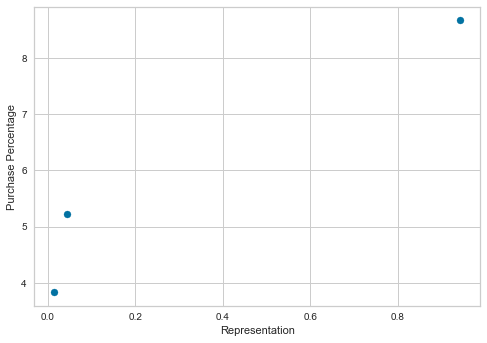

In [106]:
print('Representation Percentage=',(representation_percentage))
print('Purchase Percentage=',purchase_percentage)
import matplotlib.pyplot as plt
plt.scatter(representation_percentage,purchase_percentage)
plt.xlabel('Representation')
plt.ylabel('Purchase Percentage')
plt.show()

In [107]:
print(np.sum(purchase_percentage))

17.72377843504811


In [108]:
total_purchase=X_train.loc[X_train['Purchase']==1]

In [109]:
purchase_distrib=total_purchase.shape[0]/X_train.shape[0]
print(purchase_distrib*100)

12.0684


# This implies that cluster 0 represents 94% of the samples and has purchase ratio most similar to the overall purchase ratio. However, there exist smaller clusters with 1.4%, 4.3% population representation that represent higher purchase ratios (customers in those clusters are more sure to buy)

/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/

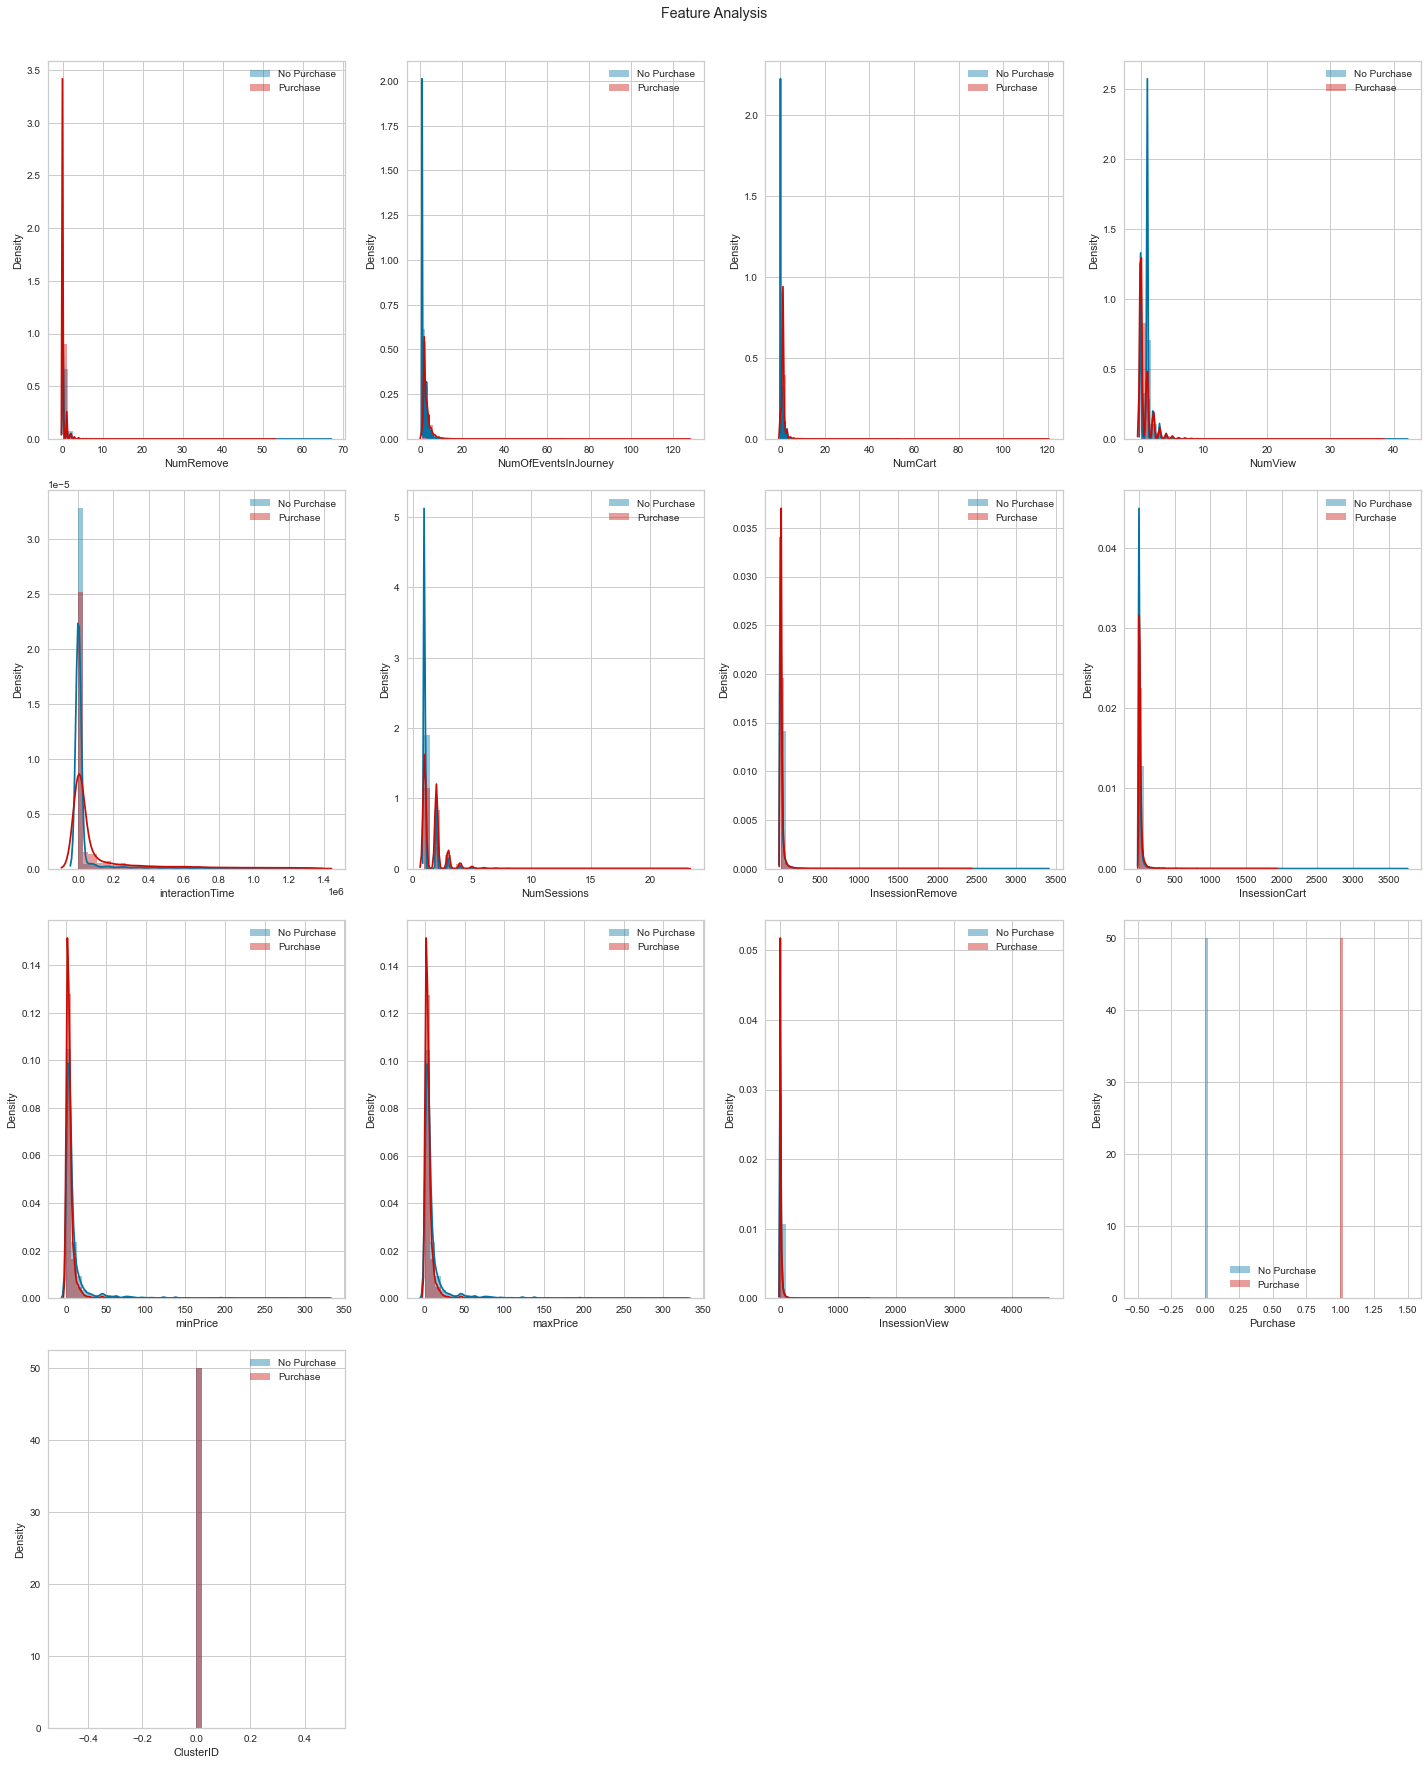

In [110]:
# Next, to analyze composition of each cluster
#Cluster 0
result = X_train.loc[X_train['ClusterID'] == 0]


fig = plt.figure(figsize = (20, 25))
j = 0
for i,item in enumerate(result.columns):
    plt.subplot(4, 4, j+1)
    j += 1
#     if(i==12):
#          sb.countplot(x='weekday', hue='Purchase', data=result)
#     elif(i==13):
#          sb.countplot(x='timeOfDay', hue='Purchase', data=result)
#     else:
#         item=None
    sb.distplot(result[item][result['Purchase']==0], color='b', label = 'No Purchase')
    sb.distplot(result[item][result['Purchase']==1], color='r', label = 'Purchase')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


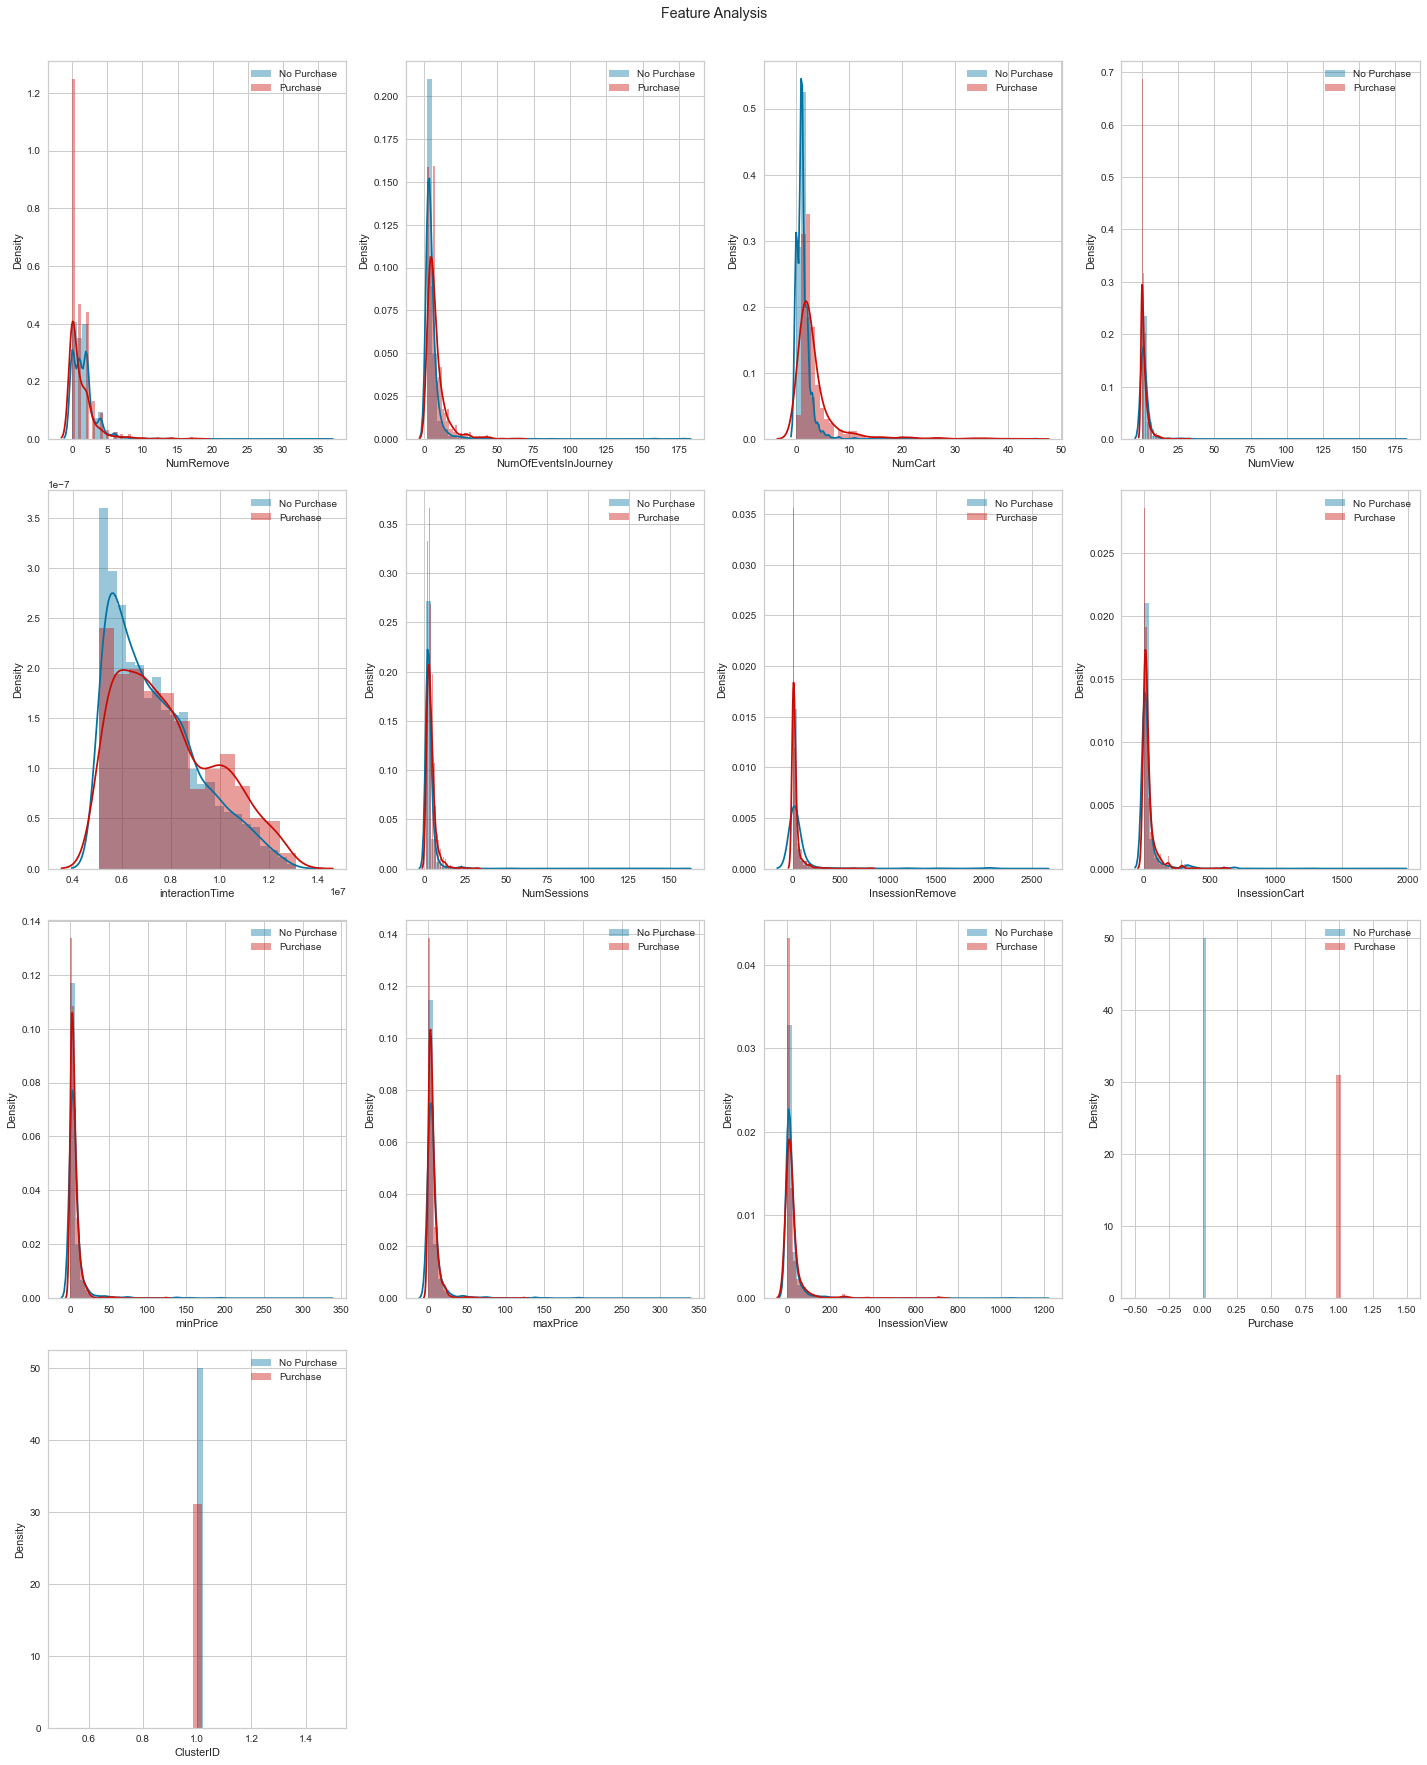

In [111]:
#Cluster 1
result = X_train.loc[X_train['ClusterID'] == 1]


fig = plt.figure(figsize = (20, 25))
j = 0
for i,item in enumerate(result.columns):
    plt.subplot(4, 4, j+1)
    j += 1

    sb.distplot(result[item][result['Purchase']==0], color='b', label = 'No Purchase')
    sb.distplot(result[item][result['Purchase']==1], color='r', label = 'Purchase')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()
    

/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/unmeshmali/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functi

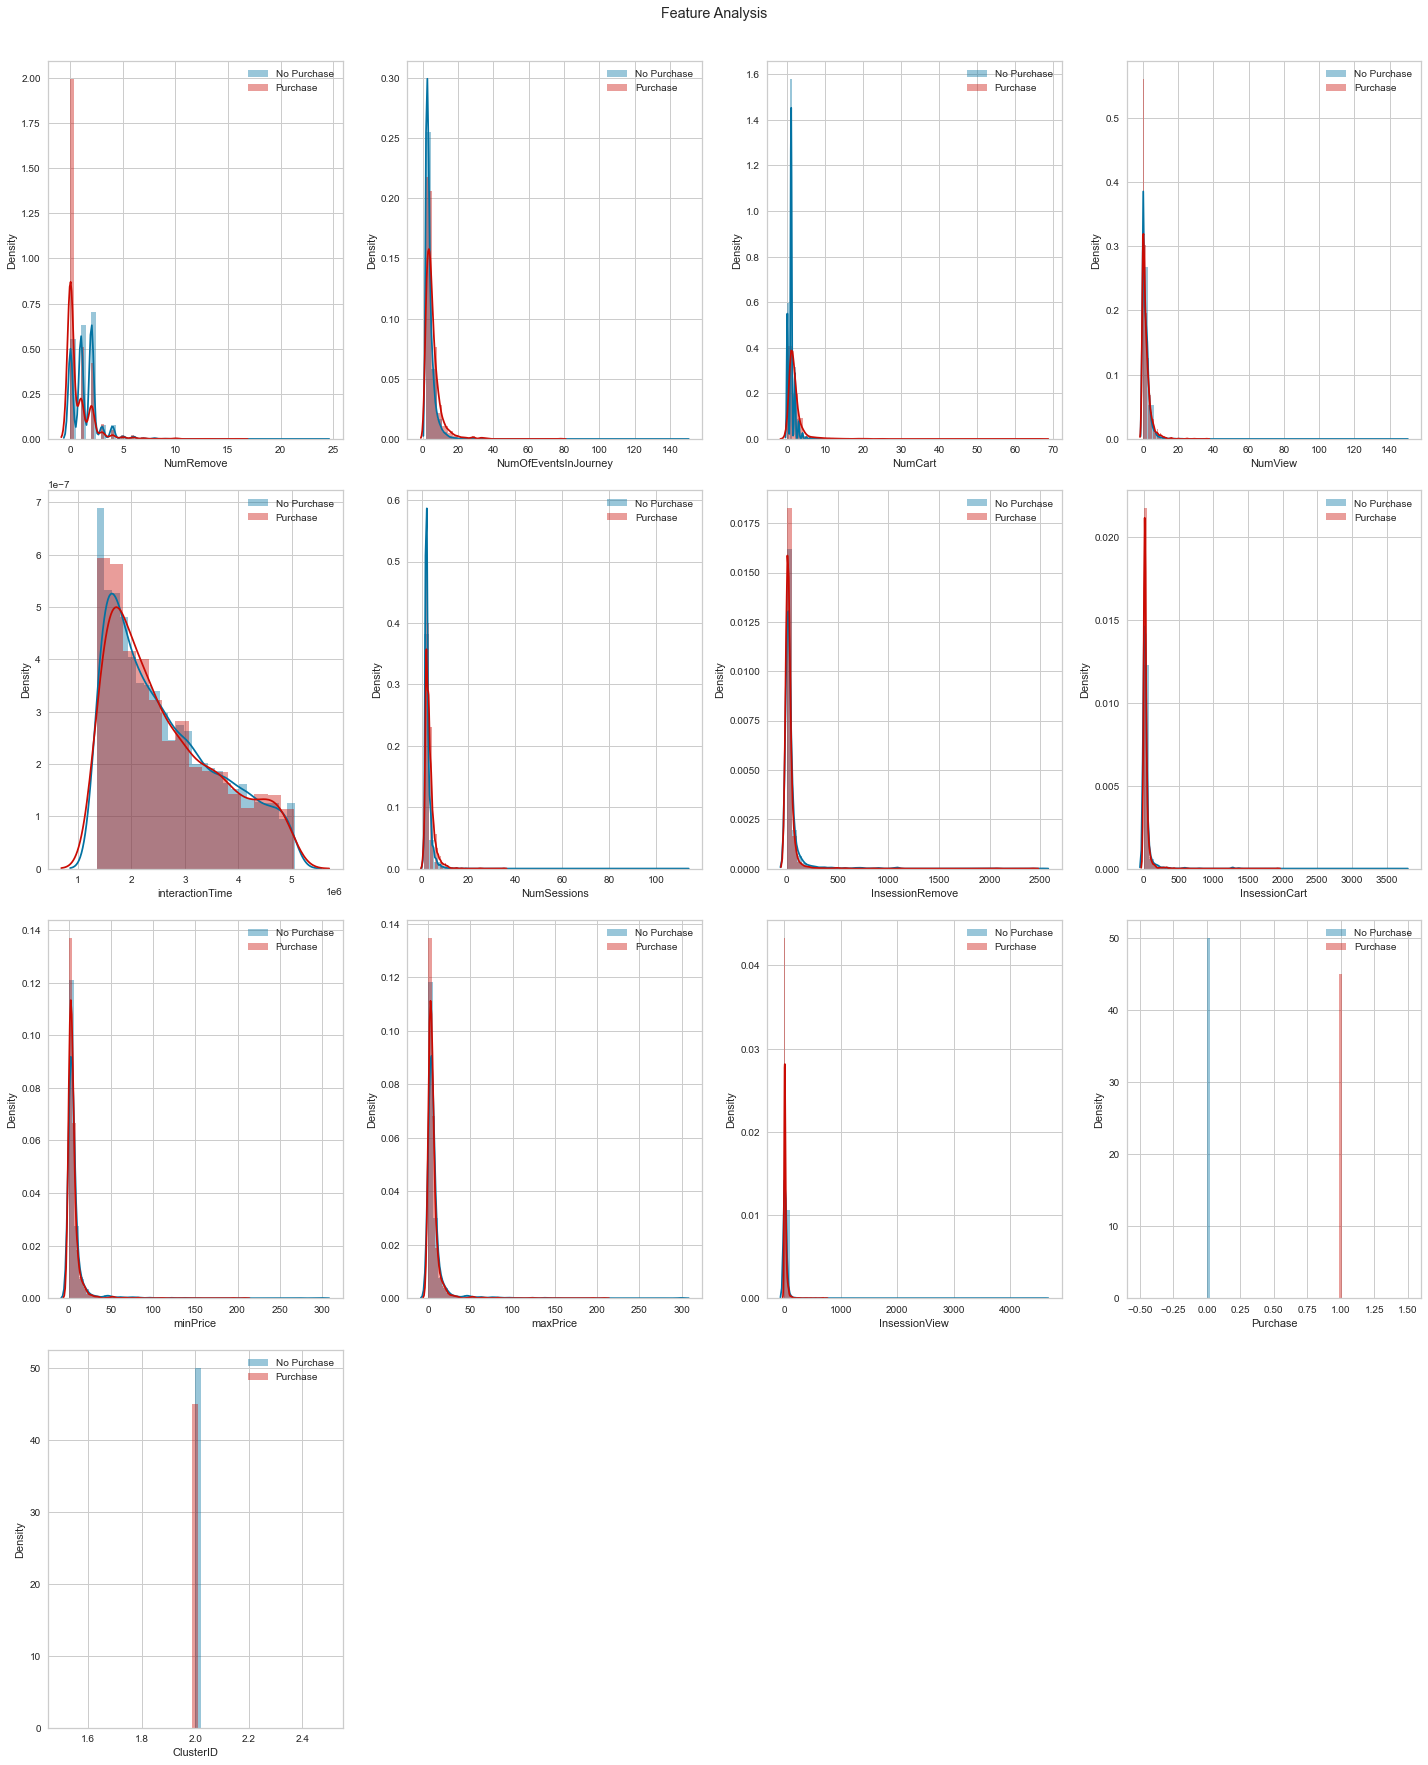

In [112]:
#Cluster 2
result = X_train.loc[X_train['ClusterID'] == 2]


fig = plt.figure(figsize = (20, 25))
j = 0
for i,item in enumerate(result.columns):
    plt.subplot(4, 4, j+1)
    j += 1
#     if(i==12):
#          sb.countplot(x='weekday', hue='Purchase', data=result)
#     elif(i==13):
#          sb.countplot(x='timeOfDay', hue='Purchase', data=result)
#     else:
#         item=None
    sb.distplot(result[item][result['Purchase']==0], color='b', label = 'No Purchase')
    sb.distplot(result[item][result['Purchase']==1], color='r', label = 'Purchase')
    plt.legend(loc='best')
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Exercise: Comment on which features are most dissimilar across clusters

# **Summary and Discussion:** **Discuss** "What would you report back as the types of user categories? What features to see here?" Refer to the paper here https://arxiv.org/pdf/2102.01625.pdf that shows 5 customer categories.
# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Can you process the data in some other way? - <font color='red'>This is session level data, looking at user-journey data might give us different insights  </font>
2. How would you ensure your "method" is optimal? - <font color='red'>Use AutoML (TPOT) to get the optimal set of algorithms and hyper parameters for our classification problem </font>
3. What is the metric/metrics you would use to report your results? What other considerations are needed for reporting the results (if any)? - <font color='red'>I would use precision, recall, and f1-score to rate the classifications </font>

#Share screen and discuss findings. Think about generalizability (something that works across data sets)